In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import requests
# from tqdm.auto import tqdm
%matplotlib inline
import random
random.seed(666)


## 1. Charger les images

In [35]:
train_images = np.load("../data/train_images.npy")
train_labels = np.load("../data/train_labels.npy")
test_images = np.load("../data/test_images.npy")
test_labels = np.load("../data/test_labels.npy")
X_train = train_images
Y_train = train_labels
X_test = test_images
Y_test = test_labels

## 2. Visualiser quelques images

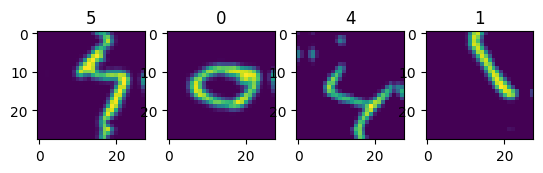

In [36]:
## the images with their label
fig, axs = plt.subplots(1,4)
for i in range(0,4):
    axs[i].imshow(train_images[i])
    axs[i].set_title(train_labels[i])
fig.savefig("../img/train_images.png")

In [37]:
# print(f'X:\n {X}')
# print(f'Y:\n {Y}')
print(f'Shape of data X:{X_train.shape}\n')
print(f'Shape of data Y:{Y_train.shape}\n')

Shape of data X:(60000, 28, 28, 1)

Shape of data Y:(60000,)



Les images ont comme dimensions 28x28 pixels, il y en a 60000.

<BarContainer object of 10 artists>

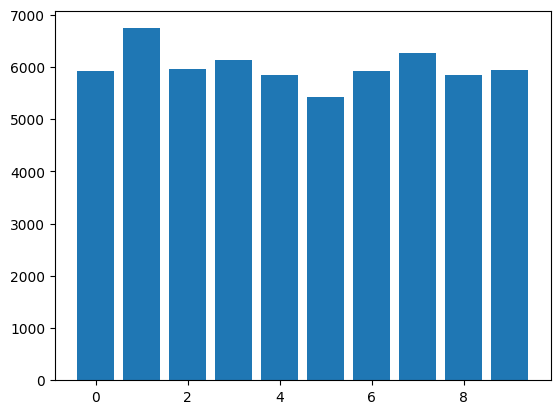

In [38]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(np.unique(Y_train), counts)

Les labels ne comportent que 10 valeurs, de 0 à 9, les chiffres contenus dans les images. 
On observe une bonne répartition, avec une entropie élevée ; l'accuracy est donc adéquate coimme métrique. 

## 3. Réaliser un premier apprentissage et une validation de la classification 

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import Conv1D, Flatten, Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model

In [40]:
callback = EarlyStopping(monitor='val_accuracy',
                         patience=10,
                         restore_best_weights=True)

In [41]:
# On transforme les valeurs en vecteur de données one-hot
Y_train_oh = to_categorical(Y_train)
Y_test_oh = to_categorical(Y_test)
print(f'Y_train shape : {Y_train.shape} ; first value = {Y_train[0]}')
print(f'Y_train_oh shape : {Y_train_oh.shape} ; first value = {Y_train_oh[0]}')

Y_train shape : (60000,) ; first value = 5
Y_train_oh shape : (60000, 10) ; first value = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [42]:
random.seed(666) ## pour être le plus reproductible possible
def make_dense1():
    """
    Ne prend pas d'arguments
    
    Retourne le premier modèle dense, selon l'énoncé :
        • fonction d'activation du neurone est une rectiﬁed linear unit
        • fonction d’activation en sortie softmax
        • la fonction coût cross-entropy
        • deux couches cachées avec 256 et 128 neurones
        • un dropout de 30 %
        • une méthode d’optimisation de type rmsprop
    """
    model = Sequential() 
    model.add(Input(shape=(28,28,1)))
    ## On transforme la donnée 2D en donnée 1D
    model.add(Flatten())
    ## Activation 'rectified linear unit'='relu' avec 256 neurones
    model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
    ## Un dropout de 30% 
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    ## 10 neurones output pour les 10 classes possibles, avec softwax pour que le total soit égal à 1
    model.add(Dense(units=10, activation='softmax'))
    ## optimiseur RMSprop
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, 
                  ## fonction de coût cross-entropie
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [43]:
model_dense1 = make_dense1()

In [44]:
plot_model(model_dense1, to_file="../img/model_dense1.png",
               show_shapes=True, show_layer_names=True)
print(f'{model_dense1.summary()}')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
hist_dense1 = model_dense1.fit(X_train, 
                             Y_train_oh, 
                             validation_split=0.2, 
                             epochs=40, 
                             batch_size=100)
## save model
model_dense1.save('../results/model_dense.v1.keras')

Epoch 1/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2439 - loss: 2.0862 - weighted_accuracy: 0.2439 - val_accuracy: 0.5511 - val_loss: 1.3688 - val_weighted_accuracy: 0.5511
Epoch 2/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5054 - loss: 1.4550 - weighted_accuracy: 0.5054 - val_accuracy: 0.6610 - val_loss: 1.0668 - val_weighted_accuracy: 0.6610
Epoch 3/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5912 - loss: 1.2184 - weighted_accuracy: 0.5912 - val_accuracy: 0.7154 - val_loss: 0.9122 - val_weighted_accuracy: 0.7154
Epoch 4/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6394 - loss: 1.0881 - weighted_accuracy: 0.6394 - val_accuracy: 0.7393 - val_loss: 0.8283 - val_weighted_accuracy: 0.7393
Epoch 5/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6705 - loss: 1.0053 - weighted_accuracy: 0.6705 - val_accuracy: 0.7609 - val_loss: 0.7651 - val_weighted_accuracy: 0.7609
Epoch 6/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


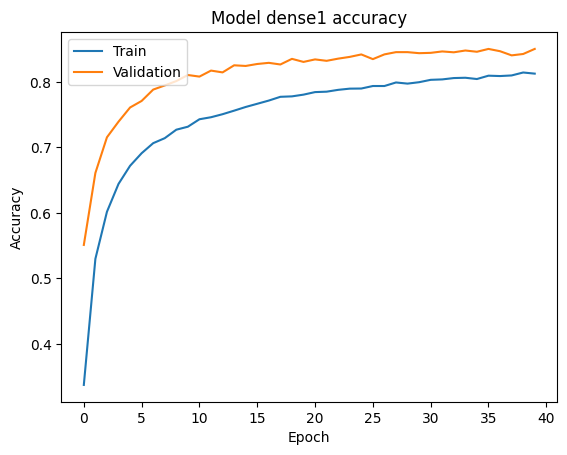

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


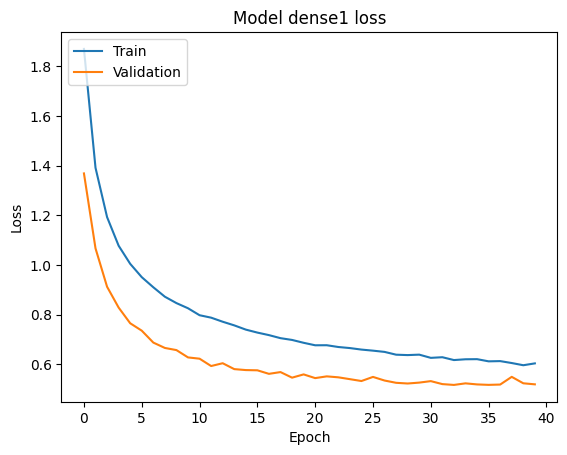

<Figure size 640x480 with 0 Axes>

In [46]:
## plot of accuracy
print(hist_dense1.history.keys())
plt.plot(hist_dense1.history['accuracy'])
plt.plot(hist_dense1.history['val_accuracy'])
plt.title('Model dense1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_dense1_accuracy')

## plot of loss
print(hist_dense1.history.keys())
plt.plot(hist_dense1.history['loss'])
plt.plot(hist_dense1.history['val_loss'])
plt.title('Model dense1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_dense1_loss')

On peut maintenant faire la cross-validation avec le jeu de données test.

In [47]:
## predict the number labels for the test image dataset
Y_pred_oh_dense1 = model_dense1.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


In [48]:
## transform back the predicted and test classes to classes
print(Y_pred_oh_dense1.shape)
print(Y_test_oh.shape)
Y_pred_classes_dense1 = np.argmax(Y_pred_oh_dense1,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes_dense1, Y_pred_classes_dense1.shape)
print(Y_test_classes, Y_test_classes.shape)


(10000, 10)
(10000, 10)
[7 2 1 ... 4 4 6] (10000,)
[7 2 1 ... 4 5 6] (10000,)


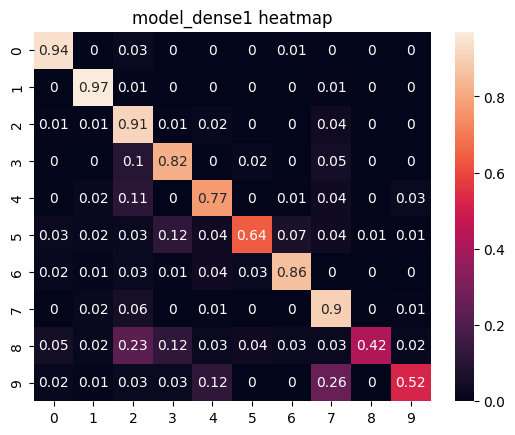

In [49]:
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense1, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_dense1 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_dense1_heatmap.png")

Maintenant pour le CNN :

In [50]:
random.seed(666)
def make_cnn1():
    """
    Ne prend pas d'arguments
    
    Retourne le premier modèle CNN, 
    avec des couches de convolution 2D :
        • fonction d'activation du neurone est une rectiﬁed linear unit
        • fonction d’activation en sortie softmax
        • la fonction coût cross-entropy
        • deux couches cachées Conv2D avec 256 et 128 neurones
        • une méthode d’optimisation de type rmsprop
    """
    model = Sequential()

    model.add(Input(shape=(28, 28,1)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                     kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
                     kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [51]:
model_cnn1 = make_cnn1()

In [52]:
plot_model(model_cnn1, to_file="../img/model_cnn1.png",
               show_shapes=True, show_layer_names=True)
print(f'{model_cnn1.summary()}')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [53]:
hist_cnn1 = model_cnn1.fit(X_train, 
                            Y_train_oh, 
                            validation_split=0.2, 
                            epochs=20, 
                            batch_size=50)
model_cnn1.save('../results/model_cnn1.keras')

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4600 - loss: 1.5765 - weighted_accuracy: 0.4600 - val_accuracy: 0.8022 - val_loss: 0.6677 - val_weighted_accuracy: 0.8022
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8004 - loss: 0.6408 - weighted_accuracy: 0.8004 - val_accuracy: 0.8483 - val_loss: 0.4874 - val_weighted_accuracy: 0.8483
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8654 - loss: 0.4452 - weighted_accuracy: 0.8654 - val_accuracy: 0.8778 - val_loss: 0.4066 - val_weighted_accuracy: 0.8778
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8952 - loss: 0.3537 - weighted_accuracy: 0.8952 - val_accuracy: 0.8979 - val_loss: 0.3333 - val_weighted_accuracy: 0.8979
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9076 - loss: 0.3025 - weighted_accuracy: 0.9076 - val_accuracy: 0.8973 - val_loss: 0.3356 - val_weighted_accuracy: 0.8973
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accura

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


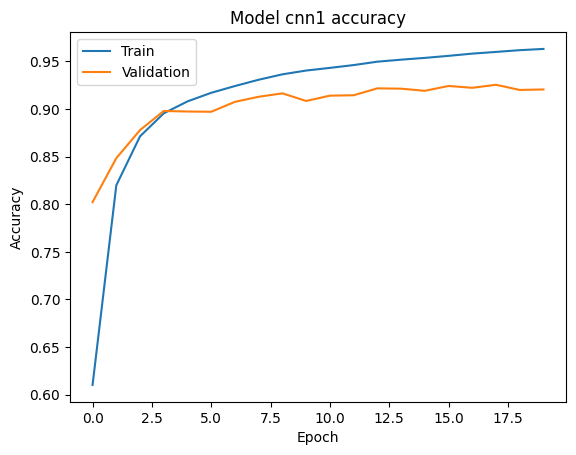

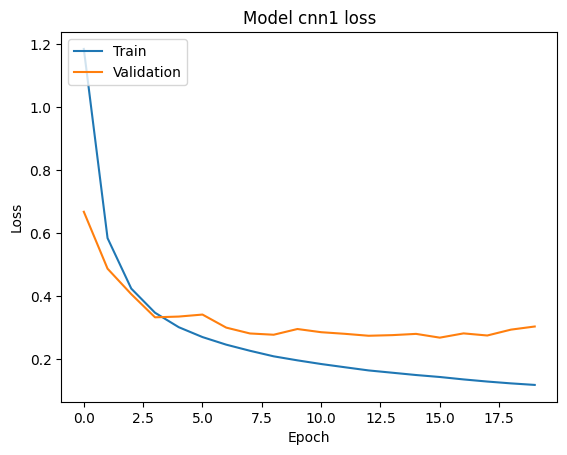

<Figure size 640x480 with 0 Axes>

In [54]:
print(hist_cnn1.history.keys())
plt.plot(hist_cnn1.history['accuracy'])
plt.plot(hist_cnn1.history['val_accuracy'])
plt.title('Model cnn1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn1_accuracy')

plt.plot(hist_cnn1.history['loss'])
plt.plot(hist_cnn1.history['val_loss'])
plt.title('Model cnn1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn1_loss')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)
(10000, 10)
[7 2 1 ... 4 9 6] 10000
[7 2 1 ... 4 5 6] 10000


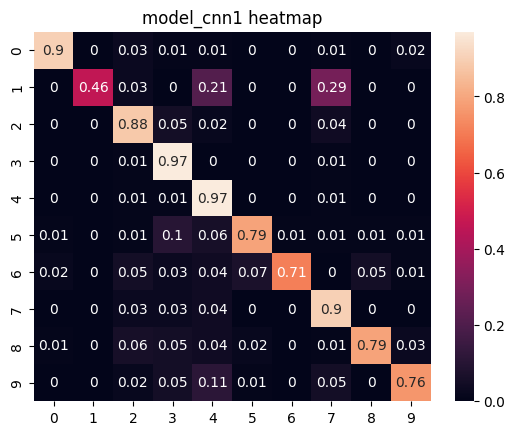

In [55]:
Y_pred_oh_cnn1 = model_cnn1.predict(X_test)
print(Y_pred_oh_cnn1.shape)
print(Y_test_oh.shape)
Y_pred_classes_cnn1 = np.argmax(Y_pred_oh_cnn1,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes_cnn1, len(Y_pred_classes_cnn1))
print(Y_test_classes, len(Y_test_classes))

conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_cnn1, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_cnn1 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_cnn1_heatmap.png")


## 5. Comparer la classification en faisant varier quelques paramètres

 Il n'est pas intéressant d'ajouter plus de 3 couches denses ; cela ne rendra pas le modèle tellement plus précis et il convergera moins bien. On peut donc en ajouter une, avec un fort bottlenecking, mais pas de dropout juste avant le softmax.

Epoch 1/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2137 - loss: 2.1339 - weighted_accuracy: 0.2137 - val_accuracy: 0.5209 - val_loss: 1.4349 - val_weighted_accuracy: 0.5209
Epoch 2/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4868 - loss: 1.5034 - weighted_accuracy: 0.4868 - val_accuracy: 0.6183 - val_loss: 1.1415 - val_weighted_accuracy: 0.6183
Epoch 3/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5724 - loss: 1.2667 - weighted_accuracy: 0.5724 - val_accuracy: 0.6957 - val_loss: 0.9459 - val_weighted_accuracy: 0.6957
Epoch 4/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6222 - loss: 1.1296 - weighted_accuracy: 0.6222 - val_accuracy: 0.7195 - val_loss: 0.8801 - val_weighted_accuracy: 0.7195
Epoch 5/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6535 - loss: 1.0455 - weighted_accuracy: 0.6535 - val_accuracy: 0.7512 - val_loss: 0.8042 - val_weighted_accuracy: 0.7512
Epoch 6/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accura

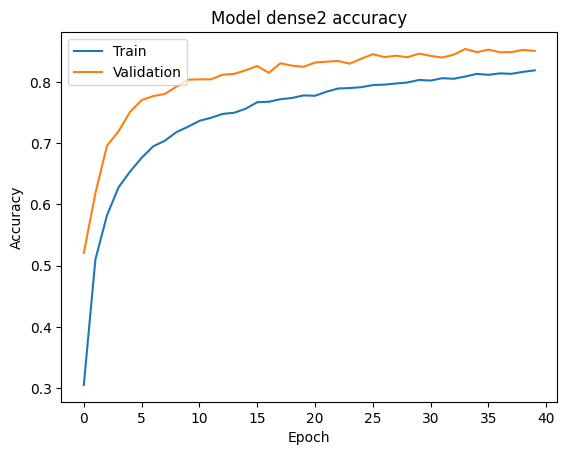

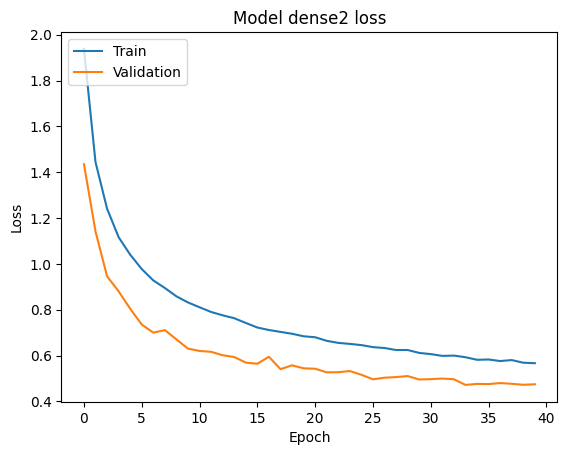

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


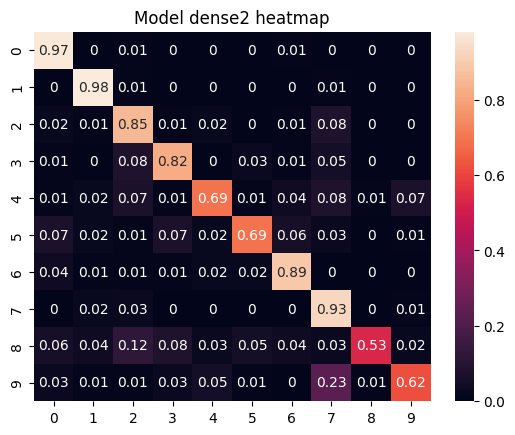

In [56]:
random.seed(666)
def make_dense2():
    """
    Ne prend pas d'arguments
    
    Retourne le deuxième modèle dense :
        • fonction d'activation du neurone est une 'rectiﬁed linear unit'
        • fonction d’activation en sortie softmax
        • la fonction coût cross-entropy
        • deux couches cachées avec 256 et 128 neurones
        • un dropout de 30 %
        • une méthode d’optimisation de type rmsprop

        • une couche dense supplémentaire
    """
    model = Sequential() 
    model.add(Input(shape=(28,28,1)))
    ## On transforme la donnée 2D en donnée 1D
    model.add(Flatten())
    ## Activation 'rectified linear unit'='relu' avec 256 neurones
    model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
    ## Un dropout de 30% 
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_uniform'))

    ## 10 neurones output pour les 10 classes possibles, avec softwax pour que le total soit égal à 1
    model.add(Dense(units=10, activation='softmax'))
    ## optimiseur RMSprop
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, 
                  ## fonction de coût cross-entropie
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

model_dense2 = make_dense2()
plot_model(model_dense2, to_file="../img/model_dense2.png",
               show_shapes=True, show_layer_names=True)
# print(f'{model_dense1.summary()}')
hist_dense2 = model_dense2.fit(X_train, Y_train_oh, 
                                  validation_split=0.2, 
                                  epochs=40, 
                                  batch_size=100)
model_dense2.save('../results/model_dense2.keras')
print(hist_dense2.history.keys())
plt.plot(hist_dense2.history['accuracy'])
plt.plot(hist_dense2.history['val_accuracy'])
plt.title('Model dense2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig("../img/model_dense2_accuracy.png")

plt.plot(hist_dense2.history['loss'])
plt.plot(hist_dense2.history['val_loss'])
plt.title('Model dense2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig("../img/model_dense2_loss.png")

Y_pred_oh_dense2 = model_dense2.predict(X_test)
# print(Y_pred_oh.shape)
# print(Y_test_oh.shape)
Y_pred_classes_dense2 = np.argmax(Y_pred_oh_dense2,axis = 1)
# Y_test_classes = np.argmax(Y_test_oh,axis = 1)
# print(Y_pred_classes, len(Y_pred_classes))
# print(Y_test_classes, len(Y_test_classes))
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('Model dense2 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_dense2_heatmap.png")

Pour le modèle en convolution, on peut ajouter une couche de neurones dense, avec 128 neurones. Cependant, il est important d'ajouter après un dropout afin d'éviter du surapprentissage. 

Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3682 - loss: 1.8073 - val_accuracy: 0.7863 - val_loss: 0.7752
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7309 - loss: 0.8318 - val_accuracy: 0.8586 - val_loss: 0.4866
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8150 - loss: 0.5859 - val_accuracy: 0.8953 - val_loss: 0.3550
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8586 - loss: 0.4627 - val_accuracy: 0.9050 - val_loss: 0.3160
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8803 - loss: 0.3841 - val_accuracy: 0.9127 - val_loss: 0.2850
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8956 - loss: 0.3349 - val_accuracy: 0.9252 - val_loss: 0.2425
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9097 - loss: 0.2923 - val_accuracy: 0.9292 - val_loss: 0.2331
Epoch 8/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9172 - loss: 0.2634 - val_accu

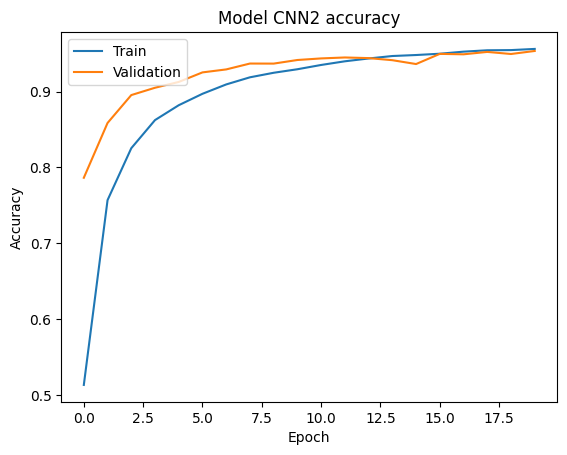

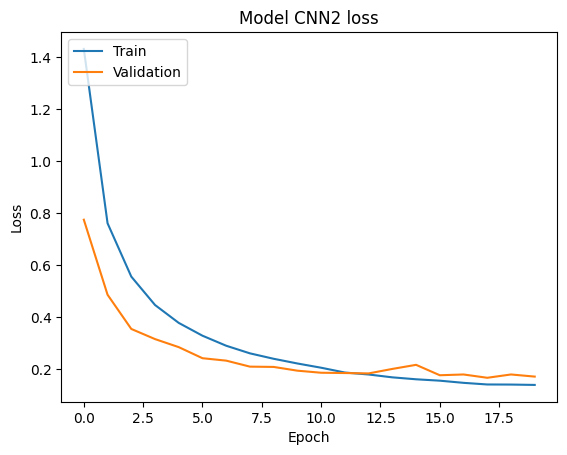

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


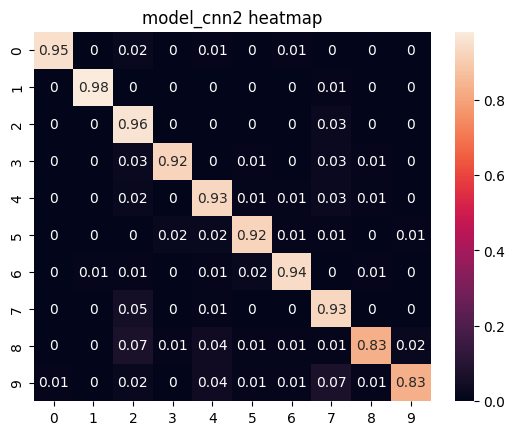

In [61]:
random.seed(666)
def make_cnn2():
    """
    Ne prend pas d'arguments
    
    Retourne le premier modèle CNN, 
    avec des couches de convolution 2D :
        • fonction d'activation du neurone est une rectiﬁed linear unit
        • fonction d’activation en sortie softmax
        • la fonction coût cross-entropy
        • deux couches cachées Conv2D avec 256 et 128 neurones
        • une méthode d’optimisation de type rmsprop

        • Une couche dense supplémentaire, avec un dropout de 30%
    """
    model = Sequential() 
    model.add(Input(shape=(28, 28,1)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    ## Add a dense layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model_cnn2 = make_cnn2()
plot_model(model_cnn2, to_file="../img/model_cnn2.png",
               show_shapes=True, show_layer_names=True)
# print(f'{model_dense1.summary()}')
hist_cnn2 = model_cnn2.fit(X_train, 
                              Y_train_oh, 
                              validation_split=0.2, 
                              epochs=20, 
                              batch_size=100)
model_cnn2.save('../results/model_cnn2.keras')
print(hist_cnn2.history.keys())
plt.plot(hist_cnn2.history['accuracy'])
plt.plot(hist_cnn2.history['val_accuracy'])
plt.title('Model CNN2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn2_accuracy')

plt.plot(hist_cnn2.history['loss'])
plt.plot(hist_cnn2.history['val_loss'])
plt.title('Model CNN2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn2_loss')

Y_pred_oh_cnn2 = model_cnn2.predict(X_test)
# print(Y_pred_oh.shape)
# print(Y_test_oh.shape)
Y_pred_classes_cnn2 = np.argmax(Y_pred_oh_cnn2,axis = 1)
# Y_test_classes = np.argmax(Y_test_oh,axis = 1)
# print(Y_pred_classes, len(Y_pred_classes))
# print(Y_test_classes, len(Y_test_classes))
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_cnn2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_cnn2 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_cnn2_heatmap.png")

## 6. Comparer les résultats des deux approches

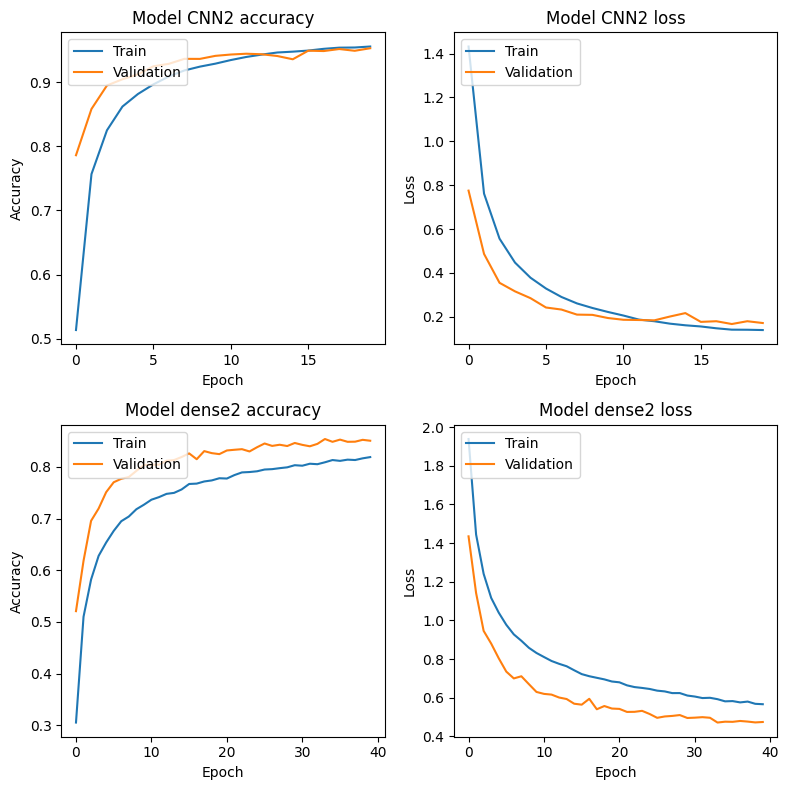

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0][0].plot(hist_cnn2.history['accuracy'])
axes[0][0].plot(hist_cnn2.history['val_accuracy'])
axes[0][0].set_title('Model CNN2 accuracy')
axes[0][0].set_ylabel('Accuracy')
axes[0][0].set_xlabel('Epoch')
axes[0][0].legend(['Train', 'Validation'], loc='upper left')

axes[0][1].plot(hist_cnn2.history['loss'])
axes[0][1].plot(hist_cnn2.history['val_loss'])
axes[0][1].set_title('Model CNN2 loss')
axes[0][1].set_ylabel('Loss')
axes[0][1].set_xlabel('Epoch')
axes[0][1].legend(['Train', 'Validation'], loc='upper left')

axes[1][0].plot(hist_dense2.history['accuracy'])
axes[1][0].plot(hist_dense2.history['val_accuracy'])
axes[1][0].set_title('Model dense2 accuracy')
axes[1][0].set_ylabel('Accuracy')
axes[1][0].set_xlabel('Epoch')
axes[1][0].legend(['Train', 'Validation'], loc='upper left')

axes[1][1].plot(hist_dense2.history['loss'])
axes[1][1].plot(hist_dense2.history['val_loss'])
axes[1][1].set_title('Model dense2 loss')
axes[1][1].set_ylabel('Loss')
axes[1][1].set_xlabel('Epoch')
axes[1][1].legend(['Train', 'Validation'], loc='upper left')

fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()
fig.savefig('../img/models_cnn2_dense2')

Le CNN a une meilleure accurary (0.9366) que le dense (0.7298) et a une function de perte plus basse (0.2272 contre 0.8590).

Text(0.5, 1.0, 'model_cnn2 heatmap')

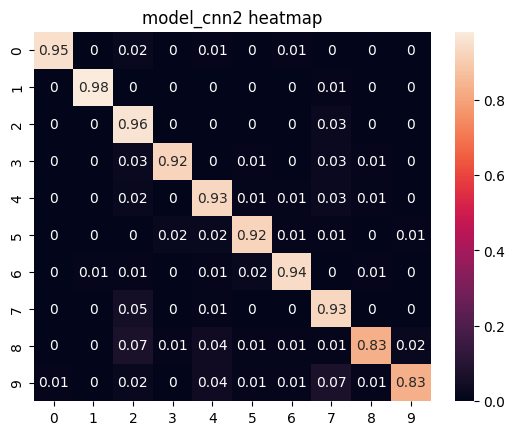

In [63]:
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_cnn2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_cnn2 heatmap')


Text(0.5, 1.0, 'model_dense2 heatmap')

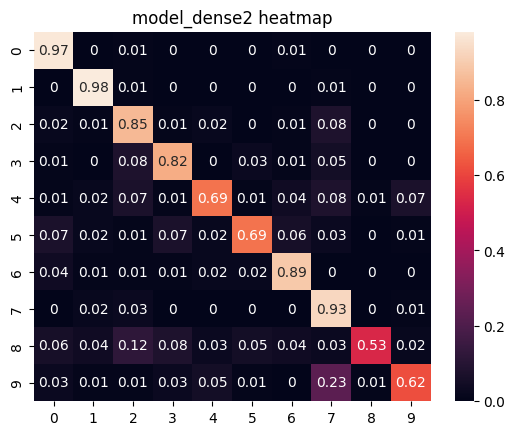

In [64]:

conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_dense2 heatmap')

L'usage de couches de convolution 2D rend le modèle beaucoup plus fiable. 

Le CNN a des meilleurs résultats sur le jeu de données test. 

En effet, la convolution 2D permet d'identifier les caractéristiques des images, et le maxpooling permet de sélectionner les caractéristiques intéressantes. Des couches denses peuvent ensuite beaucoup plus facilement identifier des motifs et apprendre à reconnaître les chiffres.  

Le CNN est donc bien meilleur pour ce type de tâche de reconnaissance d'images.